## Install the libraries

In [1]:
!pip install git+https://github.com/cleanlab/cleanlab.git
!pip install cleanlab
!pip install 'cleanlab[DataLab]'
!pip install skorch

  Cloning https://github.com/cleanlab/cleanlab.git to /tmp/pip-req-build-dghxpuo1
  Running command git clone --filter=blob:none --quiet https://github.com/cleanlab/cleanlab.git /tmp/pip-req-build-dghxpuo1
  Resolved https://github.com/cleanlab/cleanlab.git to commit 21b82a325e7828d25292c25c121b908075ab7204
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cleanlab: filename=cleanlab-2.4.1-py3-none-any.whl size=283245 sha256=edf52e592bd49cdf68578db621e47ff83c40fc886c23121516877e009fc6322c
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrbbk889/wheels/3d/53/8f/09fde0499e2135d2566a50fe7afd0398373244187206c7d441
Successfully built cleanlab
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
    

## Import Libraries

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import warnings
import math

#SEED = 123
#np.random.seed(SEED)
#torch.manual_seed(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## Fashion MNIST

Fetching the dataset

In [2]:
fashion = fetch_openml("Fashion-MNIST")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
fashion.data.shape

(70000, 784)

Reshaping the image to (70000, 1, 28, 28) => [Dimensions, Channels, Height, Weight]

In [4]:
X = fashion.data.astype("float32").to_numpy()
X = X / 255.0
X = X.reshape(len(X), 1, 28, 28)

y = fashion.target.astype("int64").to_numpy()

Plot an image

In [ ]:
T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

Data : 


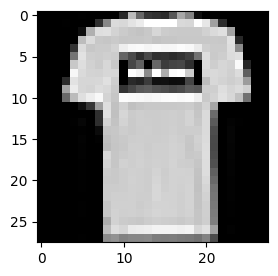

The target label is :  T-shirt/top


In [5]:
plt.figure(figsize = (3,3))
idx = 1
grid_data = fashion.data.iloc[idx].to_numpy().reshape(28,28)
print("Data : ")
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.imshow(grid_data, cmap='gray')
plt.show()

print("The target label is : ", class_labels[y[idx]])

PyTorch Model

In [6]:
from torch import nn

class FashionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

Ensuring that the model is scikit-learn compatible



In [7]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(FashionModel)

In [8]:
from sklearn.model_selection import cross_val_predict

num_crossval_folds = 5
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7017       0.8416        0.4655  8.7867
      2        0.4214       0.8696        0.3812  8.5834
      3        0.3644       0.8814        0.3444  8.7294
      4        0.3325       0.8862        0.3229  8.4850
      5        0.3101       0.8911        0.3084  8.4659
      6        0.2927       0.8956        0.2976  8.7397
      7        0.2781       0.8982        0.2891  8.6825
      8        0.2657       0.8997        0.2829  8.4196
      9        0.2548       0.9014        0.2769  8.7670
     10        0.2449       0.9021        0.2726  8.6995
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7164       0.8382        0.4711  8.2246
      2        0.4284       0.8717        0.3843  8.6959
      3        0.3670       0.8830        0.3460  8.6825
      4        0.3336       0.8

In [22]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy: %.2f%%"%(acc*100))

Cross-validated estimate of accuracy: 89.05%


In [10]:
from cleanlab import Datalab

data = {"X": X, "label": y}

In [11]:
lab = Datalab(data, label_name="label")
lab.find_issues(pred_probs=pred_probs, issue_types={"label":{}})

Finding label issues ...

Audit complete. 3255 issues found in the dataset.


In [12]:
issue_results = lab.get_issues("label")
issue_true = issue_results[issue_results['is_label_issue'] == True]

In [36]:
issue_true.head()

,is_label_issue,label_score,given_label,predicted_label
4,True,0.069643,0,1
24,True,0.169320,4,2
32,True,0.217312,6,4
61,True,0.214355,0,6
169,True,0.001096,0,4


**Changing the labels**

In [19]:
for i in issue_true.index:
  y[i] = issue_true[issue_true.index == i]['predicted_label']

Label IDs :  [1106, 2477, 2869, 3337, 4143, 5385, 6510, 9404, 10209, 13624]
No. of wrong labels :  10


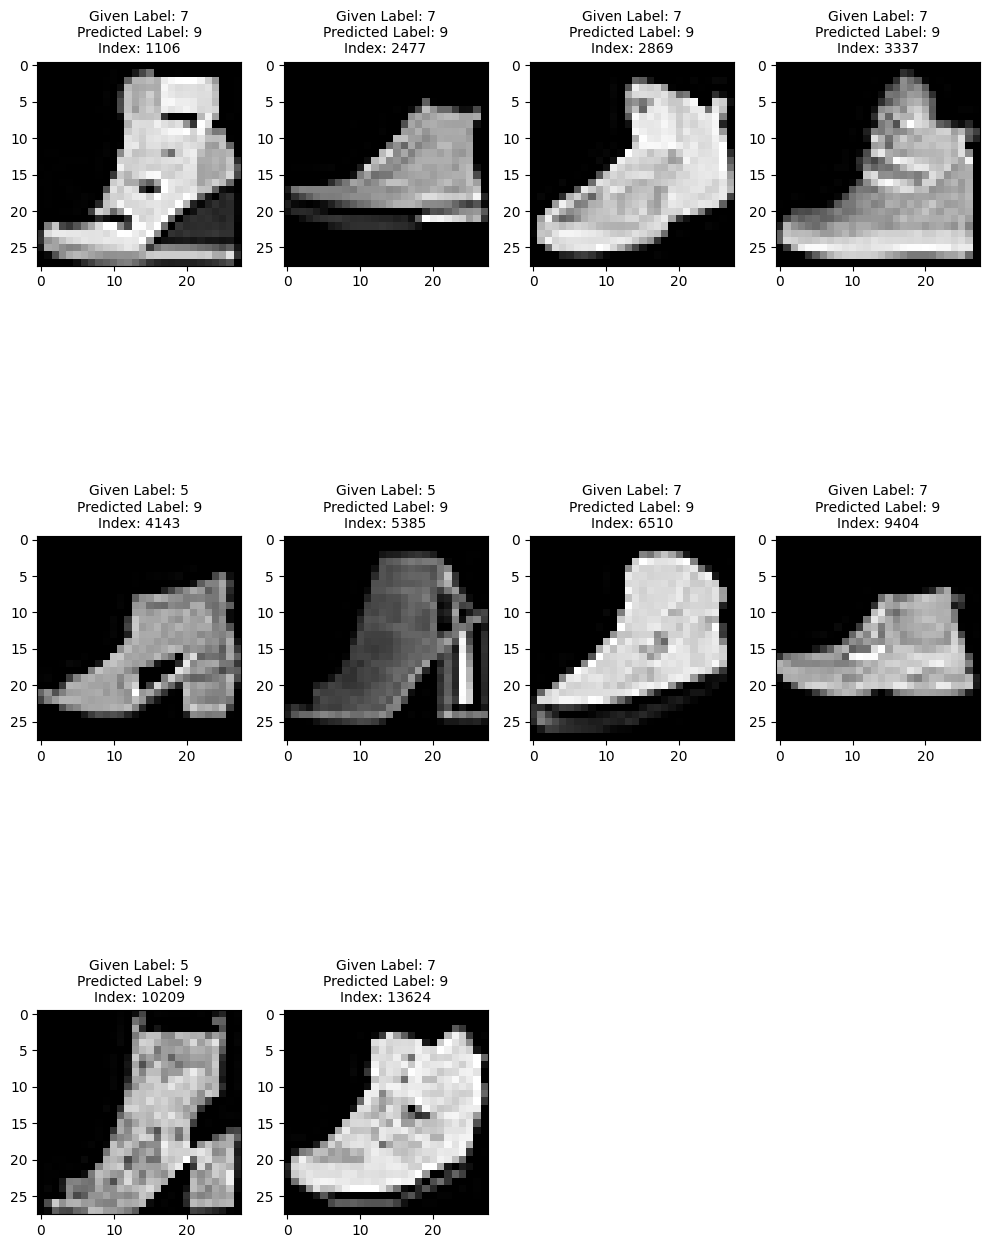

In [24]:
classes = 9
locations = []
for i in range(0, len(issue_true)):
  loc = issue_true.iloc[i].predicted_label
  if(loc == classes):
    locations.append(issue_true.index[i])

locations = locations[0:10]

print("Label IDs : ", locations)
print("No. of wrong labels : ", len(locations))
rows = math.ceil(len(locations)/4)

if(rows>1):
  count = 0
  fig, axs = plt.subplots(nrows = rows, ncols = 4, figsize=(10, 15))
  for r in range(rows):
    for c in range(4):
      if(count<len(locations)):
        l = locations[count]
        axs[r][c].imshow(X[l].reshape(28, 28), cmap = 'gray')
        axs[r][c].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
        count += 1
      else:
        fig.delaxes(axs[r][c])
  plt.tight_layout()
else:
  count = 0
  fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10, 15))
  for i in range(4):
    if(count < len(locations)):
      l = locations[count]
      axs[i].imshow(X[l].reshape(28, 28), cmap = 'gray')
      axs[i].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
      count += 1
    else:
      fig.delaxes(axs[i])


Training the model again

In [21]:
num_crossval_folds = 5  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6505       0.8487        0.4285  9.0613
      2        0.3474       0.8745        0.3492  9.3388
      3        0.2817       0.8840        0.3155  8.6356
      4        0.2453       0.8912        0.2996  9.0304
      5        0.2212       0.8973        0.2856  9.0697
      6        0.2035       0.9009        0.2776  8.9218
      7        0.1894       0.9048        0.2685  8.5528
      8        0.1775       0.9054        0.2644  8.9696
      9        0.1674       0.9085        0.2604  8.9165
     10        0.1585       0.9101        0.2569  8.5135
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6580       0.8479        0.4253  8.6842
      2        0.3530       0.8772        0.3370  8.9820
      3        0.2847       0.8906        0.2994  8.8799
      4        0.2472       0.8

In [9]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy: %.2f%%"%(acc*100))

Cross-validated estimate of accuracy: 89.53%


**Security-related issue**

Delibrately changing some labels

In [25]:
y[[480, 650, 547, 222, 346, 388, 979, 675, 789, 1111, 1323]] = 0
y[[943, 545, 723, 1444, 1832]] = 1
y[[1943, 3333, 221, 101]] = 5

In [26]:
data = {"X": X, "label": y}

In [27]:
lab = Datalab(data, label_name="label")
lab.find_issues(pred_probs=pred_probs, issue_types={"label":{}})

Finding label issues ...

Audit complete. 3082 issues found in the dataset.


In [28]:
issue_results = lab.get_issues("label")
issue_true = issue_results[issue_results['is_label_issue'] == True]

Label IDs :  [221, 1943, 3333, 15392, 19928, 22504, 26270, 26790, 27550, 30151, 34959, 39262, 39872, 40628, 41163, 44779, 46360, 51747, 53488, 60722, 64405, 68532]
No. of wrong labels :  22


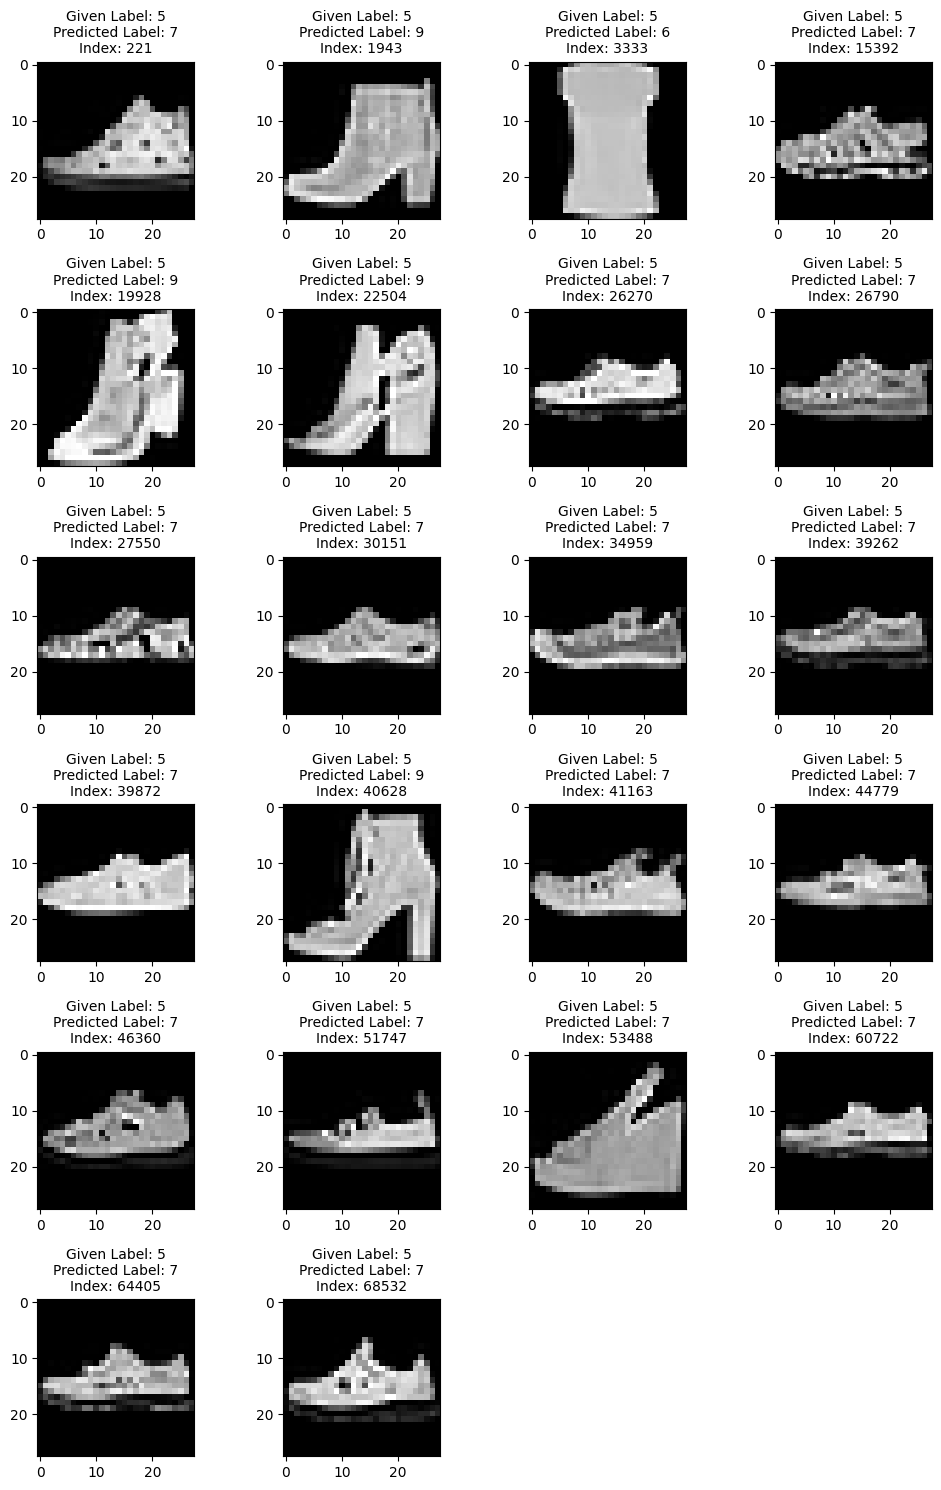

In [29]:
classes = 5
locations = []
for i in range(0, len(issue_true)):
  loc = issue_true.iloc[i].given_label
  if(loc == classes):
    locations.append(issue_true.index[i])

print("Label IDs : ", locations)
print("No. of wrong labels : ", len(locations))
rows = math.ceil(len(locations)/4)

if(rows>1):
  count = 0
  fig, axs = plt.subplots(nrows = rows, ncols = 4, figsize=(10, 15))
  for r in range(rows):
    for c in range(4):
      if(count<len(locations)):
        l = locations[count]
        axs[r][c].imshow(X[l].reshape(28, 28), cmap = 'gray')
        axs[r][c].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
        count += 1
      else:
        fig.delaxes(axs[r][c])
  plt.tight_layout()
else:
  count = 0
  fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(10, 15))
  for i in range(4):
    if(count < len(locations)):
      l = locations[count]
      axs[i].imshow(X[l].reshape(28, 28), cmap = 'gray')
      axs[i].set_title("Given Label: "+ str(issue_results.iloc[l].given_label)+"\nPredicted Label: "+str(issue_results.iloc[l].predicted_label)+"\nIndex: "+str(l), fontsize='medium')
      count += 1
    else:
      fig.delaxes(axs[i])


In [72]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [49]:
import numpy as np


Data : 


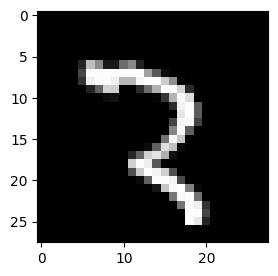

The target label is :  3


In [74]:
plt.figure(figsize = (3,3))
idx = 500
grid_data = training_data[idx]
print("Data : ")
plt.imshow(training_data[idx][0].squeeze(),cmap='gray')
plt.show()
print("The target label is : ", training_data[idx][1])

In [75]:
from torch import nn

class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [76]:
!pip install skorch

In [77]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(ClassifierModule)

In [61]:
import numpy as np

In [80]:
data = []
labels = []

for image, label in training_data:
    data.append(image.numpy())
    labels.append(label)
X_train = np.array(data)
y_train = np.array(labels)

In [88]:
data = []
labels = []

for image, label in test_data:
    data.append(image.numpy())
    labels.append(label)
X_test = np.array(data)
y_test = np.array(labels)

In [82]:
from sklearn.model_selection import cross_val_predict

num_crossval_folds = 3  # for efficiency; values like 5 or 10 will generally work better
pred_probs = cross_val_predict(
    model_skorch,
    X_train,
    y_train,
    cv=num_crossval_folds,
    method="predict_proba",
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8396       0.9227        0.3117  4.5989
      2        0.2332       0.9466        0.1924  5.4982
      3        0.1634       0.9576        0.1518  4.1886
      4        0.1316       0.9621        0.1293  4.1631
      5        0.1120       0.9663        0.1145  4.6894
      6        0.0984       0.9680        0.1037  4.0721
      7        0.0881       0.9695        0.0955  4.0612
      8        0.0800       0.9718        0.0890  4.5768
      9        0.0735       0.9740        0.0837  4.0937
     10        0.0681       0.9752        0.0794  4.4577


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8353       0.9260        0.3155  4.0598
      2        0.2526       0.9471        0.1994  4.6866
      3        0.1786       0.9556        0.1561  4.9014
      4        0.1431       0.9627        0.1333  4.0560
      5        0.1214       0.9655        0.1194  4.5006
      6        0.1064       0.9686        0.1091  4.4301
      7        0.0952       0.9696        0.1016  4.6336
      8        0.0865       0.9706        0.0959  4.6868
      9        0.0795       0.9715        0.0912  4.4276
     10        0.0736       0.9721        0.0875  5.1763


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7458       0.9374        0.2793  4.1657
      2        0.2158       0.9553        0.1775  4.1323
      3        0.1543       0.9617        0.1422  4.6302
      4        0.1254       0.9649        0.1235  4.2477
      5        0.1078       0.9686        0.1120  4.3063
      6        0.0956       0.9694        0.1034  4.5593
      7        0.0866       0.9709        0.0967  4.1262
      8        0.0794       0.9724        0.0918  4.7986
      9        0.0737       0.9741        0.0874  4.2416
     10        0.0689       0.9752        0.0836  4.2021


In [100]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y_train, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9734666666666667


In [85]:
!pip install cleanlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 3.1 MB/s eta 0:00:00


In [99]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    y_train,
    pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n{ranked_label_issues}")

Cleanlab found 113 label issues.
Top 15 most likely label errors: 
[24798 59915  8729 59701   902 26560  2676 31134 53216 30049 49543  7010
 51248  7080 50239 20773 13082  1604 20672 10251 43658 19124 33388  2720
 35616 37038 12183 50632 10994 35234 40378 30604 52324 17551 44848 25678
 26376 28556 57662  9098 12559  8898 11885  4502  6848 27254  6448 51944
 43454 46373 37834 19244 20735  9472 24938 25800 39184 51600  8904 28652
  2098 29062  6658 31962 12679 14582 39683 26626 50329 56596 39377 33768
 41396 15450 21348 25562 43783 45761 27155 51986 50698 46435 11536 13452
 12778 33130 41284  5718 32419 28310 20903 20018 30810  5896 34902  7530
 39425 42566 52801 34615 55598 31428 36104 12585 24274 31274  1244 55870
 34750 45888 26749 31547 24432]


In [103]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from labelrefinery import LabelRefinery

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LabelRefinery model and fit it on the training data
refinery = LabelRefinery()
refinery.fit(X_train, y_train)

# Refine the labels of the testing data
refined_labels = refinery.refine(X_test)

# Train a machine learning model using refined labels
model = LogisticRegression(max_iter=100)
model.fit(X_train, refined_labels)

# Evaluate the model using original and refined labels
original_accuracy = model.score(X_test, y_test)
refined_accuracy = model.score(X_test, refined_labels)

print(f"Original Accuracy: {original_accuracy:.4f}")
print(f"Refined Accuracy: {refined_accuracy:.4f}")

ERROR: Could not find a version that satisfies the requirement labelrefinery (from versions: none)
ERROR: No matching distribution found for labelrefinery


ModuleNotFoundError: ignored

In [2]:
!pip install dirty_cat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 2.2 MB/s eta 0:00:00


In [4]:
import numpy as np
from dirty_cat import datasets, label_noise

# Load a synthetic dataset with categorical features
X, y = datasets.load_categorical(n_samples=100, n_features=2, n_informative=2, n_clusters_per_class=1, random_state=42)

# Introduce label noise
np.random.seed(42)
y_noisy = np.where(y == 0, np.random.choice([0, 1], size=len(y), p=[0.9, 0.1]), y)

# Correct noisy labels using the LabelEncoder from dirty_cat
encoder = label_noise.clean_label()
y_corrected = encoder.fit_transform(X, y_noisy)

# Print the original, noisy, and corrected labels
print("Original Labels:", y)
print("Noisy Labels:", y_noisy)
print("Corrected Labels:", y_corrected)

ImportError: ignored